In [4]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from tabulate import tabulate

In [5]:
# Load datasets
train_incubator = pd.read_csv('train_incubator.csv')
test_sf2 = pd.read_csv('test_sf2.csv')

# Check number of examples per class
print (train_incubator['class'].value_counts())
print (test_sf2['class'].value_counts())

class
arabiensis_female    3000
culex_female         3000
funestus_female      3000
gambiae_female       3000
Name: count, dtype: int64
class
gambiae_female       600
culex_female         522
funestus_female      512
arabiensis_female    428
Name: count, dtype: int64


查看每个数据是否重要

In [3]:
train_incubator.head()

,class,file_path,file_size,file_error,duration,bit_depth,bitrate,sample_rate,channels,year,...,M_harmcherry_wbf_coeffofvariation,M_harmcherry_wbf_trustworthyharmonics,M_skips_thresh,M_skips_count,M_skips_density,M_skips_score,date,sensor,species,sex
0,arabiensis_female,2023-09-06_330016_Arabiensis_female/002/2 002.wav,11016.0,OK,0.060952,16.0,1411200.0,44100.0,2.0,2023.0,...,0.007115,7.0,0.05,0.0,0.0,1.086296e-06,2023-09-06,330016,Arabiensis,female
1,arabiensis_female,2023-09-06_330016_Arabiensis_female/002/2 001.wav,7944.0,OK,0.043537,16.0,1411200.0,44100.0,2.0,2023.0,...,0.006407,8.0,0.05,0.0,0.0,5.488865e-07,2023-09-06,330016,Arabiensis,female
2,arabiensis_female,2023-09-06_330016_Arabiensis_female/002/3 000.wav,16648.0,OK,0.092880,16.0,1411200.0,44100.0,2.0,2023.0,...,0.005084,8.0,0.05,0.0,0.0,6.383632e-07,2023-09-06,330016,Arabiensis,female
3,arabiensis_female,2023-09-06_330017_Arabiensis_female/002/3 004.wav,13064.0,OK,0.072562,16.0,1411200.0,44100.0,2.0,2023.0,...,0.107716,7.0,0.05,0.0,0.0,1.581738e-06,2023-09-06,330017,Arabiensis,female
4,arabiensis_female,2023-09-06_330017_Arabiensis_female/002/2 003.wav,7432.0,OK,0.040635,16.0,1411200.0,44100.0,2.0,2023.0,...,0.007066,8.0,0.05,0.0,0.0,5.296662e-07,2023-09-06,330017,Arabiensis,female


In [78]:
# Define feature sets
special_features = ['temperature', 'duration', 'humidity', 'hour', 'luminosity', 'altitude', 'air_pressure']
wbf_features = ['L_harmcherry_wbf_mean','L_harmcherry_wbf_stddev']
freq_features = [f'L_harmcherry_h{i}_freq' for i in range(1,9)]
basefreq_features = [f'L_harmcherry_h{i}_basefreq' for i in range(1,9)]
relbasefreq_features = [f'L_harmcherry_h{i}_relbasefreq' for i in range(1,9)]
power_features = [f'L_harmcherry_h{i}_power' for i in range(1,9)]
relpower_features = [f'L_harmcherry_h{i}_relpower' for i in range(1,9)]
invented_features = [f'L_harmcherry_h{i}_invented' for i in range(1,9)]

In [79]:
feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X_train = pd.DataFrame(train_incubator, columns=feature_set)
y_train = train_incubator['class'].values 

X_test = pd.DataFrame(test_sf2, columns=feature_set)
y_test = test_sf2['class'].values

In [8]:
fe_se =special_features+['class']
X_train1 = pd.DataFrame(train_incubator, columns=fe_se)

In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,12000.0,27.000000,3.415793,22.000000,24.000000,27.000000,30.000000,32.000000
duration,12000.0,0.051261,0.022774,0.026122,0.037732,0.043537,0.055147,0.476009
humidity,12000.0,79.384308,6.224371,39.700000,76.900000,79.700000,81.300000,101.600000
L_harmcherry_wbf_mean,12000.0,554.219411,68.416022,339.346860,505.955067,550.258254,599.151064,831.516958
L_harmcherry_wbf_stddev,12000.0,6.189685,5.736486,0.262688,2.956682,4.775300,7.593755,89.500719
L_harmcherry_h1_freq,12000.0,557.354514,69.370983,333.471297,508.754444,553.652931,602.528636,837.025739
L_harmcherry_h2_freq,12000.0,1109.024169,137.646472,676.419009,1012.534912,1101.892139,1199.080584,1654.620834
L_harmcherry_h3_freq,12000.0,1662.334974,206.801062,1015.678166,1516.400235,1651.038979,1797.435387,2516.734196
L_harmcherry_h4_freq,12000.0,2215.265193,275.602154,1335.604373,2021.058053,2200.078634,2396.068119,3328.453862
L_harmcherry_h5_freq,12000.0,2768.158574,344.209309,1694.725603,2524.655412,2749.939972,2991.719691,4172.625812


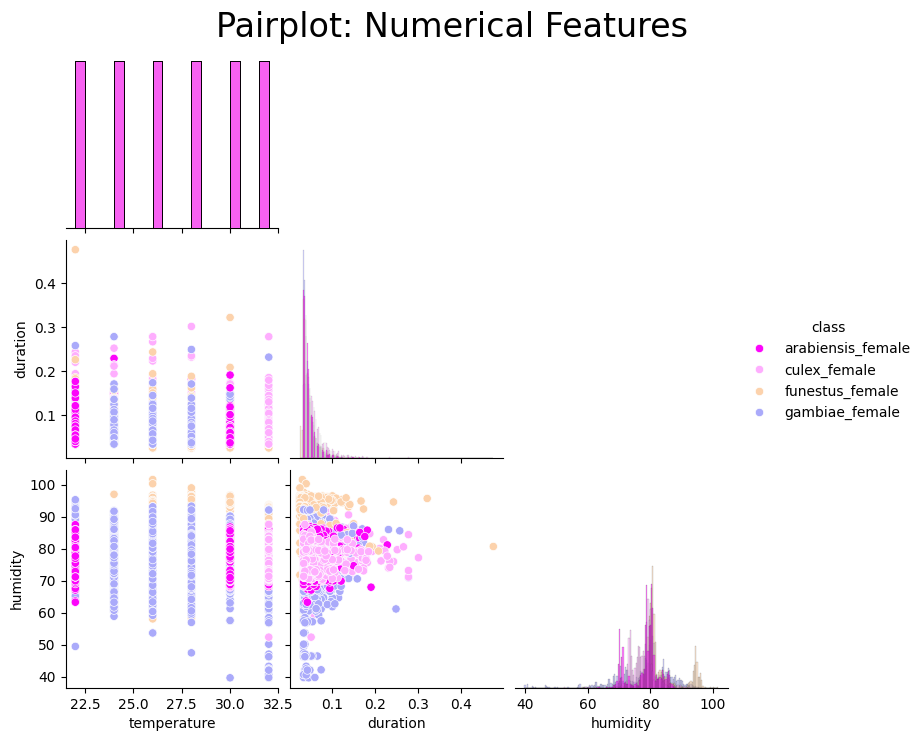

In [14]:
# data_ = data[_]
import seaborn as sns
import matplotlib.pyplot as plt

mypal= ['#FC05FB', '#FEAEFE', '#FCD2AC','#AAAAFA', '#B4FFA4','#3FFEBA']
g = sns.pairplot(X_train1, hue="class", corner=True, diag_kind='hist', palette=mypal[:4]);
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 24);

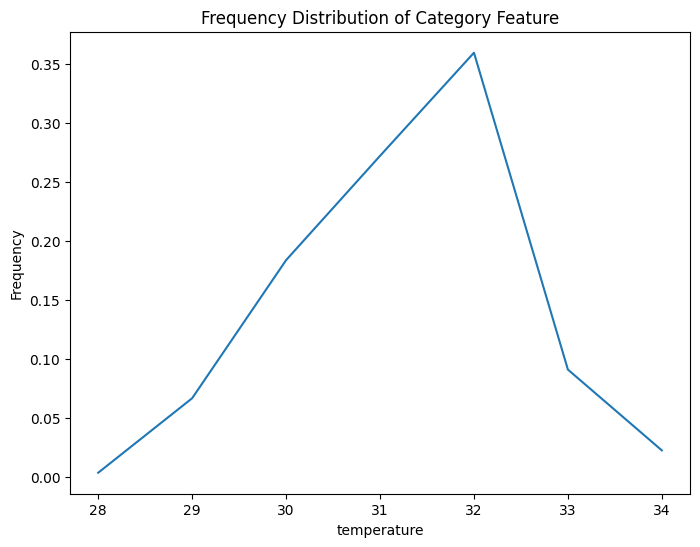

culex_female
arabiensis_female
gambiae_female
funestus_female


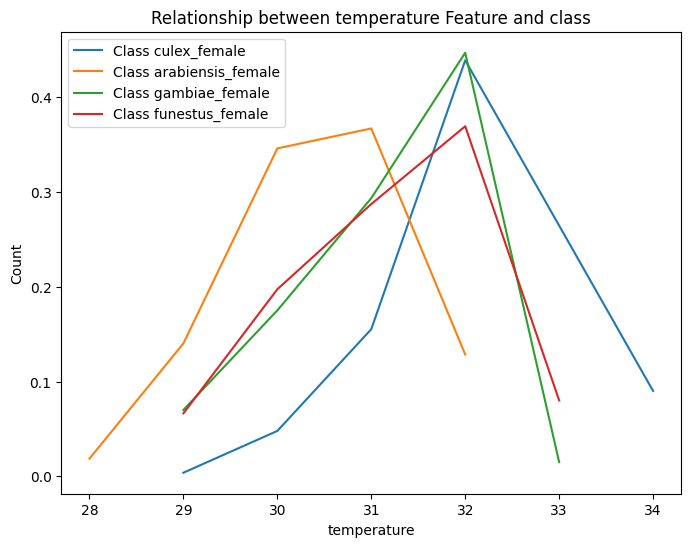

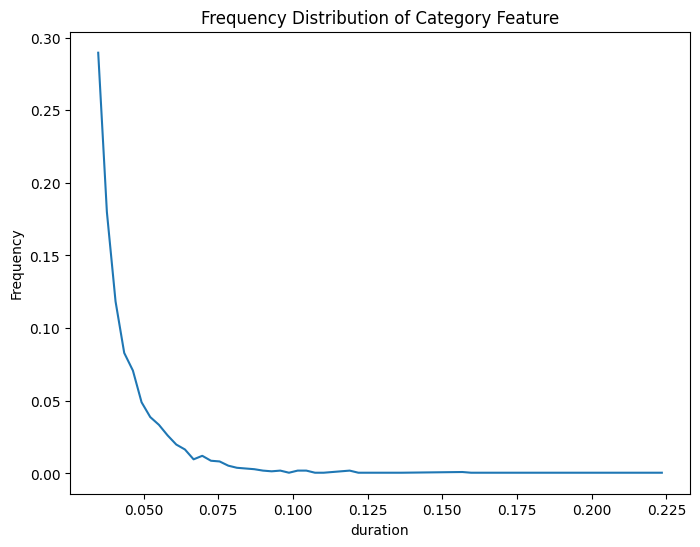

culex_female
arabiensis_female
gambiae_female
funestus_female


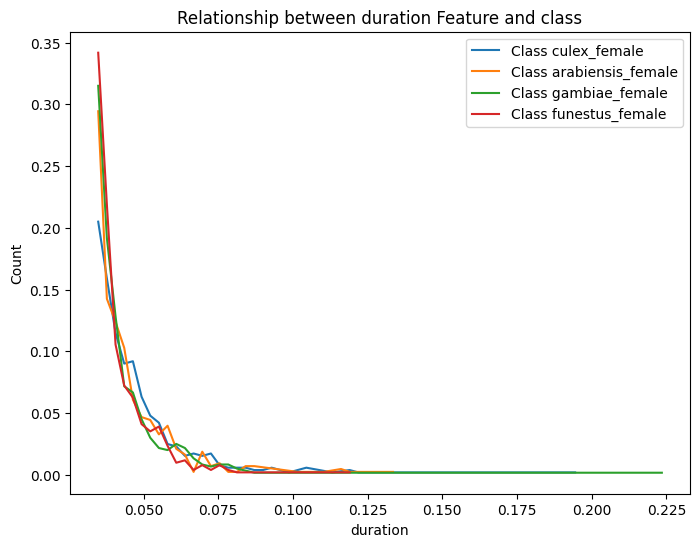

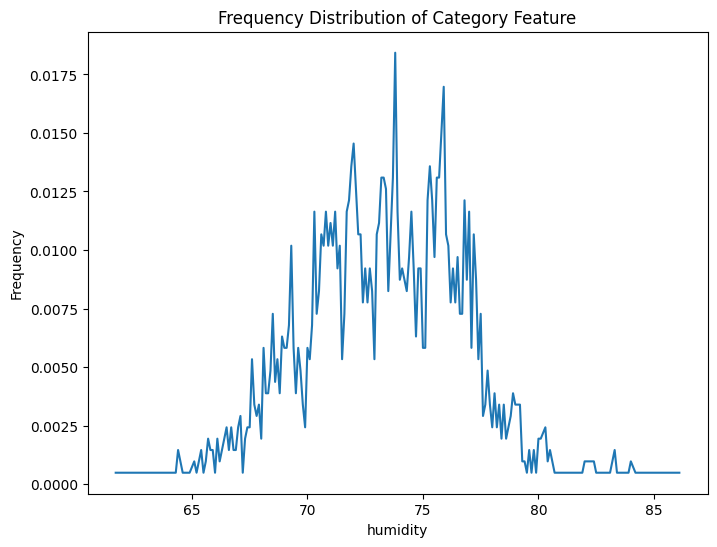

culex_female
arabiensis_female
gambiae_female
funestus_female


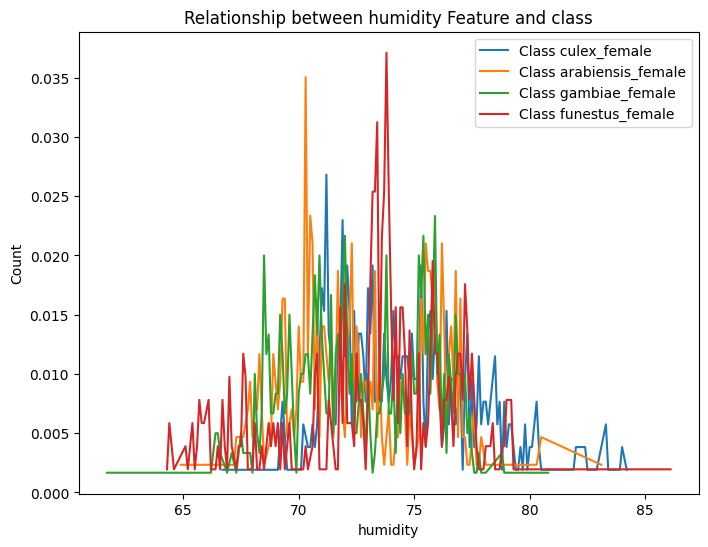

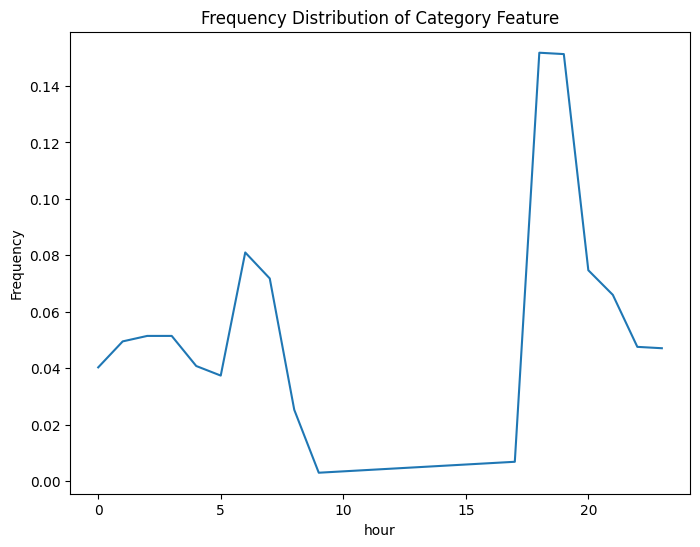

culex_female
arabiensis_female
gambiae_female
funestus_female


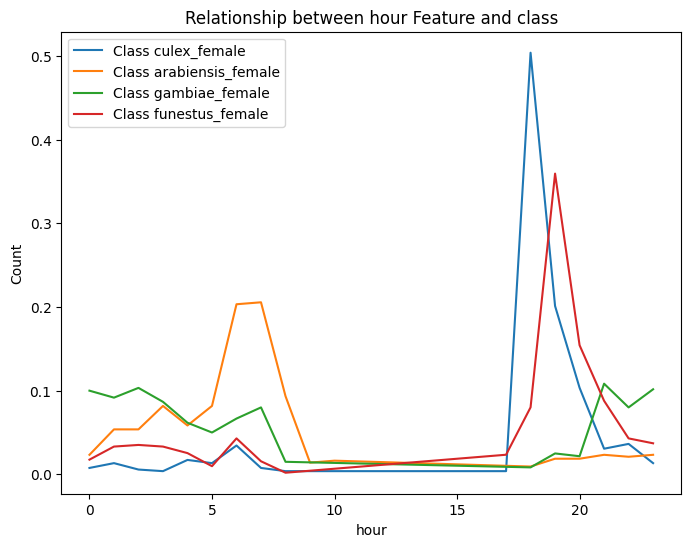

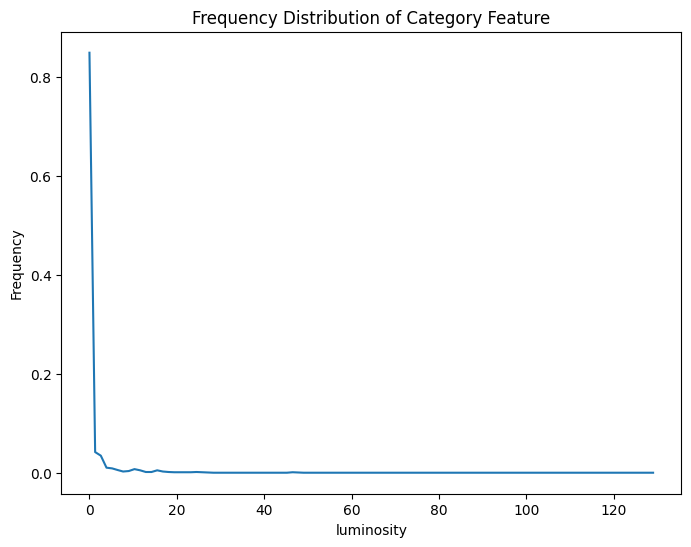

culex_female
arabiensis_female
gambiae_female
funestus_female


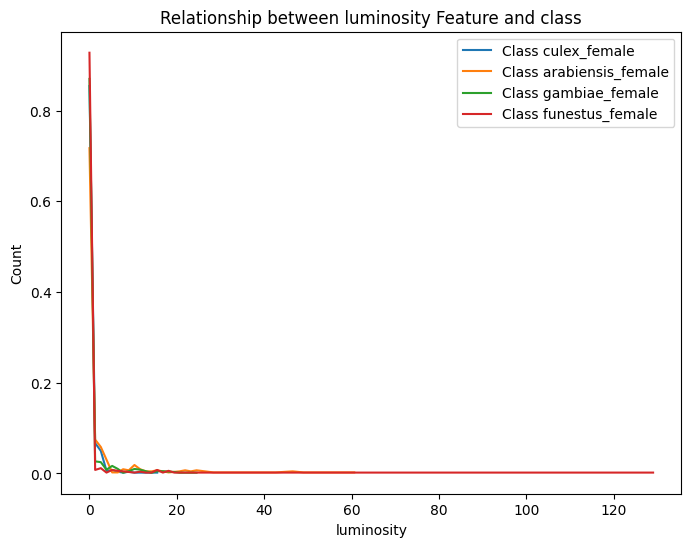

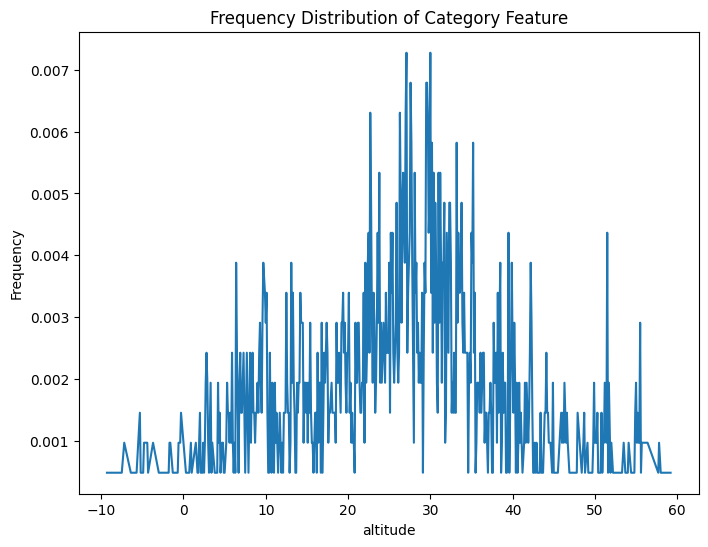

culex_female
arabiensis_female
gambiae_female
funestus_female


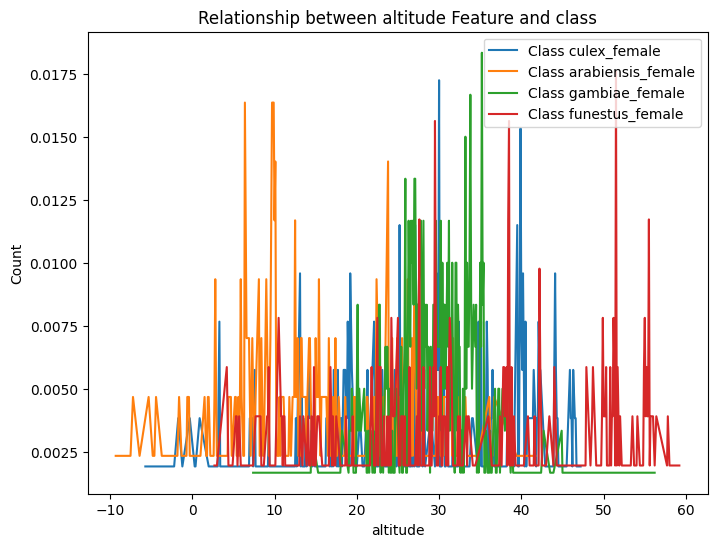

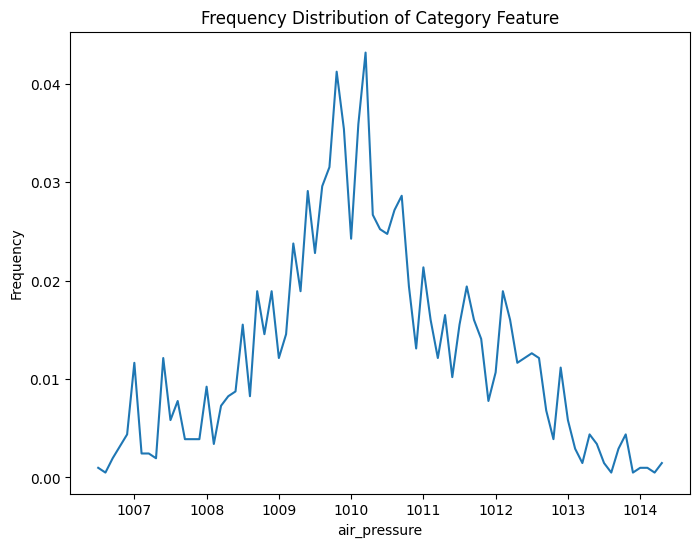

culex_female
arabiensis_female
gambiae_female
funestus_female


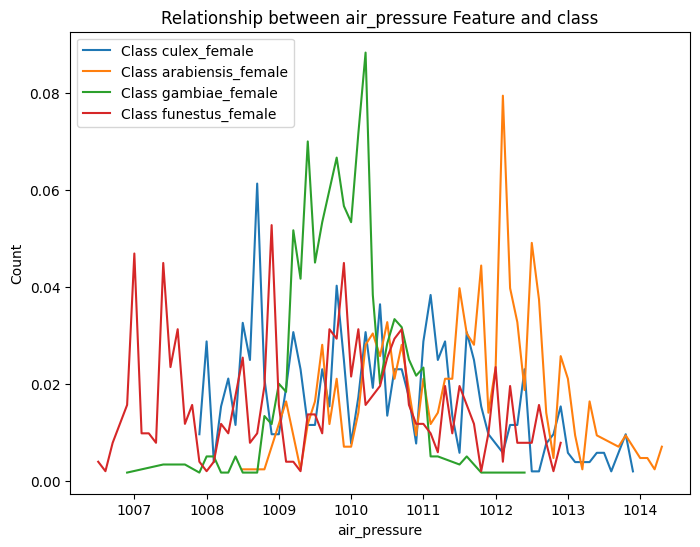

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for item in special_features:
  df = pd.DataFrame(test_sf2, columns=[item, 'class'])

  # Calculate frequency distribution for each category
  category_counts = df[item].value_counts(normalize=True)
 
  # Visualize the frequency distribution of different categories
  plt.figure(figsize=(8, 6))
  sns.lineplot(x=category_counts.index, y=category_counts.values)
  plt.title('Frequency Distribution of Category Feature')
  plt.xlabel(item)
  plt.ylabel('Frequency')
  plt.show()

  # Explore relationships between categorical features and target variables
  plt.figure(figsize=(8, 6))
  for class_val in df['class'].unique():
    class_df = df[df['class'] == class_val]
    print(class_val)
    category_counts = class_df.value_counts(normalize=True)
    sns.lineplot(x=category_counts.index.get_level_values(0), y=category_counts.values, label=f'Class {class_val}')
  plt.title(f'Relationship between {item} Feature and class')
  plt.xlabel(item)
  plt.ylabel('Count')
  plt.legend()
  plt.show()


In [15]:
# Train and test a LGBM model
models = [('LGBM', lightgbm.LGBMClassifier()),
         ]

for name, model in models:
    print("Model: ", name)
    
    model.fit(X_train, y_train)
    
    p_labels = model.predict(X_test)
    a_labels = y_test
    acc = accuracy_score(a_labels, p_labels)
    
    print("\tAcc: %.4f" % acc)
    print (classification_report(a_labels, p_labels, labels=np.unique(y_test)))
        
    cf = confusion_matrix(a_labels, p_labels, labels=np.unique(y_train))
    print(tabulate(cf, headers=np.unique(y_train), tablefmt='fancy_grid'))

Model:  LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8986
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 37
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
	Acc: 0.4840
                   precision    recall  f1-score   support

arabiensis_female       0.23      0.22      0.23       428
     culex_female       0.52      0.54      0.53       522
  funestus_female       0.93      0.46      0.62       512
   gambiae_female       0.45      0.64      0.53       600

         accuracy                           0.48      2062
        macro avg       0.53      0.47      0.48      2062
     weighted avg       0.54      0.48      0.49      

Model:  LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8981
[LightGBM] [Info] Number of data points in the train set: 9395, number of used features: 37
[LightGBM] [Info] Start training from score -1.379823
[LightGBM] [Info] Start training from score -1.321889
[LightGBM] [Info] Start training from score -1.412937
[LightGBM] [Info] Start training from score -1.434148
Evaluation results for fold 1: {'valid_0': OrderedDict([('multi_error', [0.4886756238003839, 0.45297504798464494, 0.44452975047984644, 0.4391554702495202, 0.4383877159309021, 0.4322456813819578, 0.4257197696737044, 0.42418426103646834, 0.42303262955854126, 0.42495201535508637, 0.4207293666026871, 0.418809980806142, 0.4161228406909789, 0.418809980806142, 0.418042226487524, 0.418426103646833, 0.4157389635316699, 0.41381957773512473, 0.41381957773512473, 0.4157389635316699, 0.41689

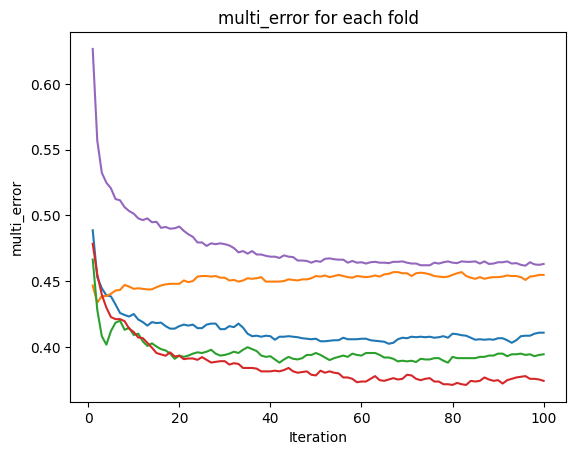

Accuracy:  0.5806241056180648


In [16]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



# Train and test a LGBM model
feature_set = special_features+wbf_features+freq_features+basefreq_features+relbasefreq_features+power_features

X = pd.DataFrame(train_incubator, columns=feature_set)
y = train_incubator['class'].values
groups = train_incubator['sensor'].values

print("Model: ", 'LGBM')

# 创建GroupKFold对象，指定分组和折数
group_kfold = GroupKFold(n_splits=5)

model = lightgbm.LGBMClassifier()

sum = 0
multi_error_scores = []

for fold_idx, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups=groups), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='multi_error')
    p_labels = model.predict(X_test)
    acc = accuracy_score(y_test, p_labels)
    
    sum += acc

    eval_results = model.evals_result_
    print(f"Evaluation results for fold {fold_idx}: {eval_results}")
    # 绘制multi_error曲线
    plt.plot(range(1, len(eval_results['valid_0']['multi_error']) + 1), eval_results['valid_0']['multi_error'], label=f"Fold {fold_idx}")

# plt.plot(range(1, 6), multi_error_scores, marker='o')
plt.xlabel('Iteration')
plt.ylabel('multi_error')
plt.title('multi_error for each fold')
plt.show()

print("Accuracy: ", sum / 5)